# Validation of self developed ViT
Testing autoencoder capabilities of our developed Vision Transformer and compare it to a popular off-the-shelf model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../src')

from vit import Embedding, ViT_Encoder, CrossSelfDecoder

In [2]:
# simple MNIST example

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
valset = datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

train_subset = torch.utils.data.Subset(trainset, range(10))
trainloader_10 = DataLoader(train_subset, batch_size=10, shuffle=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(valset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 28063424.78it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13673743.52it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25699888.51it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6477568.44it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [3]:
# Some helper functions

def plot_images(images, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def getViT(D, patch_size, encoder_blocks, encoder_heads, decoder_blocks, decoder_heads, channel=1, device='cpu'):
    embedding = Embedding(D, patch_size, channel, 28//patch_size * 28//patch_size)
    encoder = ViT_Encoder(D, encoder_heads, [128, nn.ReLU()], encoder_blocks)
    decoder = CrossSelfDecoder(D, decoder_heads, [128, nn.ReLU()], decoder_blocks)

    embedding.to(device)
    encoder.to(device)
    decoder.to(device)
    
    return (embedding, encoder, decoder)

def forward(x, model):
    embedding, encoder, decoder = model
    y = embedding.embedding(x)
    y = encoder(y)
    y = decoder(y)
    y = embedding.unembedding(y)
    return y

def train(trainloader, model, optimizer, epochs, valloader=None, example_images=None, device=None, epoch_progress=False):
    if example_images is not None:
        plot_images(example_images.detach().cpu().numpy(), min(10, len(example_images)))
    
    print_images = max(1, epochs // 10)
    loss_history = []
    valloss_history = []

    epoch_loader = range(epochs)
    if not epoch_progress:
        epoch_loader = tqdm(epoch_loader)
    for epoch in epoch_loader:
        epoch_loss = 0.0
        loader = trainloader
        if epoch_progress:
            loader = tqdm(trainloader)
        for (images, _) in loader:
            x = images.to(device)
            y = forward(x, model)
            loss = F.mse_loss(y, x)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_history.append(epoch_loss / len(trainloader))

        if valloader is not None:
            valloss = 0.0
            for (images, _) in valloader:
                x = images.to(device)
                with torch.no_grad():
                    y = forward(x, model)
                loss = F.mse_loss(y, x)
                valloss += loss.item()
            valloss_history.append(valloss / len(valloader))

        if epoch % print_images == 0:
            print(f"Epoch {epoch+1} loss: {epoch_loss / len(trainloader)}")
            if example_images is not None:
                y = forward(example_images, model)
                plot_images(y.detach().cpu().numpy(), min(10, len(example_images)))
    return loss_history, valloss_history

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Overfitting to 10 samples
Shows that the ViT is able to learn. 

In [4]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
print("Using device=", device)

embedding, encoder, decoder = getViT(D=128, patch_size=2, encoder_blocks=1, encoder_heads=4, decoder_blocks=1, decoder_heads=4, device=device)

optimizer = optim.Adam(list(embedding.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
example_images = next(iter(trainloader_10))[0][:10].to(device)

Using device= mps


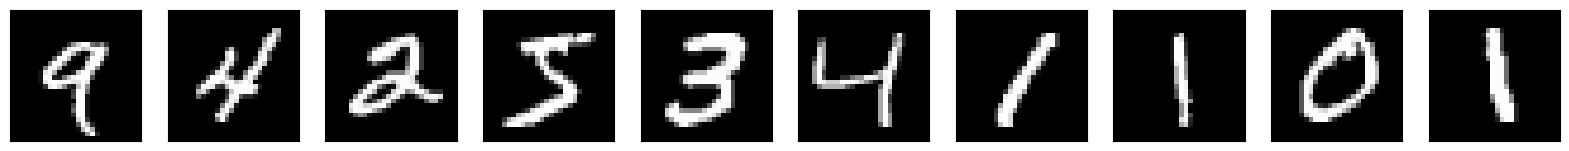

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 loss: 1.0514897108078003


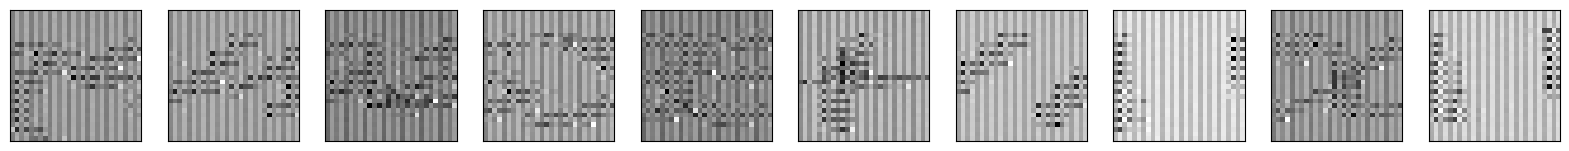

 10%|▉         | 49/500 [00:08<00:29, 15.38it/s]

Epoch 51 loss: 0.15701551735401154


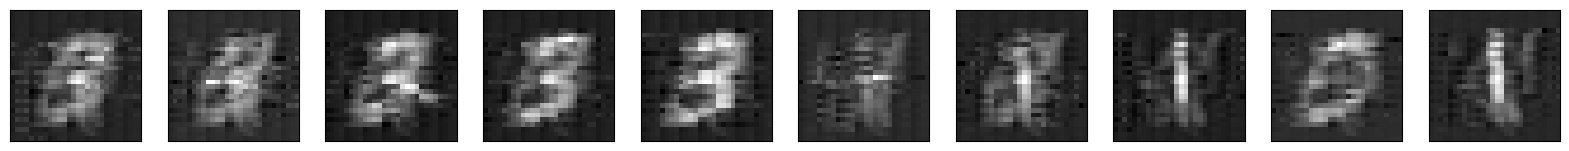

 20%|█▉        | 99/500 [00:12<00:27, 14.44it/s]

Epoch 101 loss: 0.05200779065489769


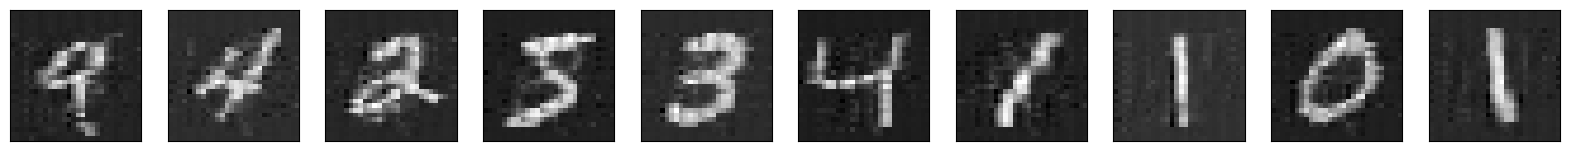

 30%|██▉       | 149/500 [00:15<00:23, 15.03it/s]

Epoch 151 loss: 0.011503505520522594


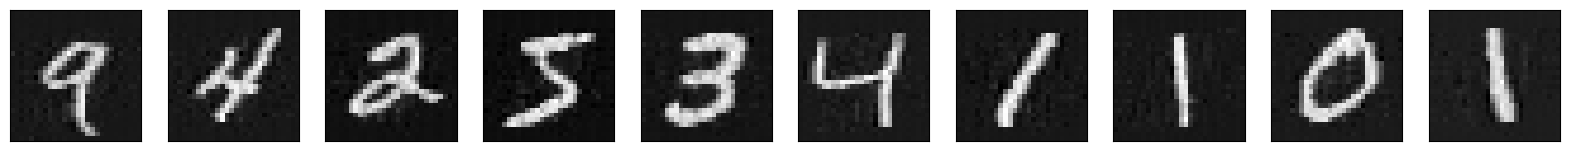

 40%|████      | 200/500 [00:20<00:21, 13.65it/s]

Epoch 201 loss: 0.005564416758716106


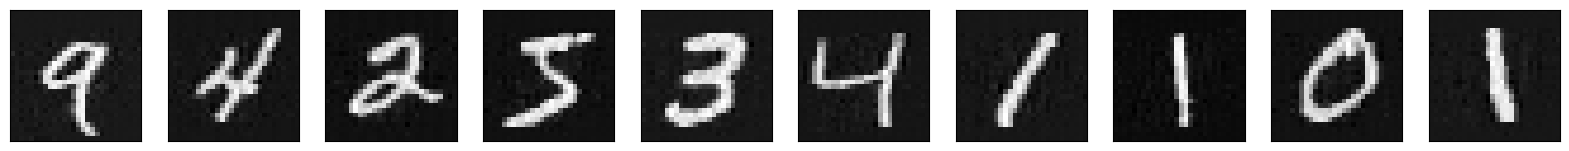

 50%|████▉     | 249/500 [00:23<00:15, 15.88it/s]

Epoch 251 loss: 0.003602867014706135


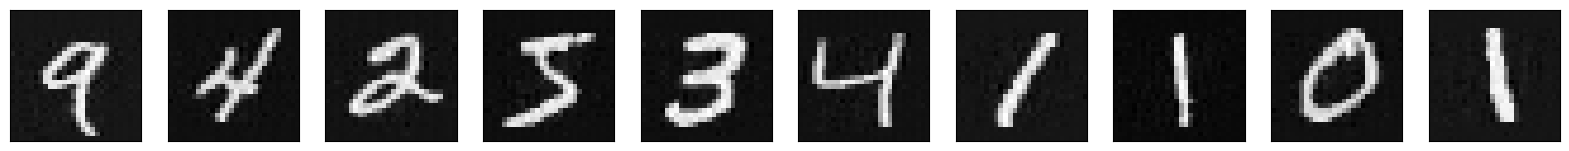

 60%|█████▉    | 299/500 [00:27<00:13, 15.09it/s]

Epoch 301 loss: 0.0026331900153309107


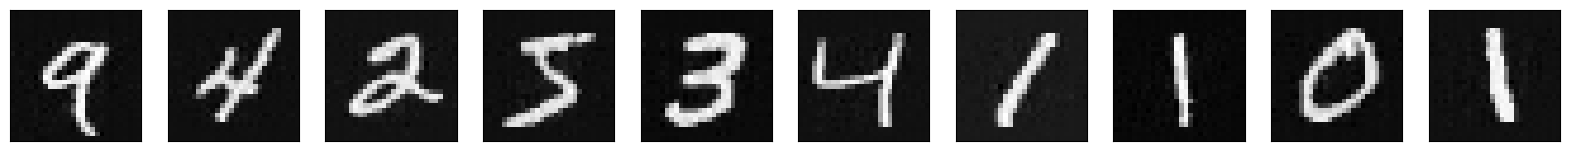

 70%|███████   | 350/500 [00:32<00:11, 12.99it/s]

Epoch 351 loss: 0.0020952147897332907


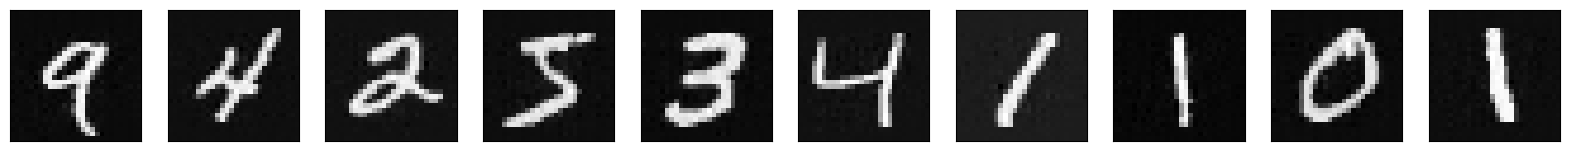

 80%|████████  | 400/500 [00:35<00:07, 12.68it/s]

Epoch 401 loss: 0.0011368088889867067


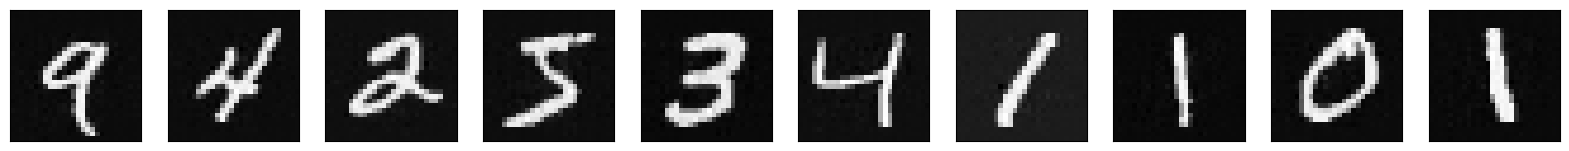

 90%|█████████ | 450/500 [00:39<00:03, 16.38it/s]

Epoch 451 loss: 0.0017859800718724728


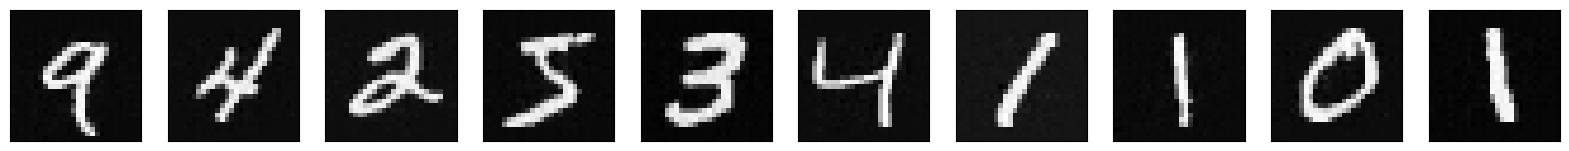

100%|██████████| 500/500 [00:42<00:00, 11.68it/s]


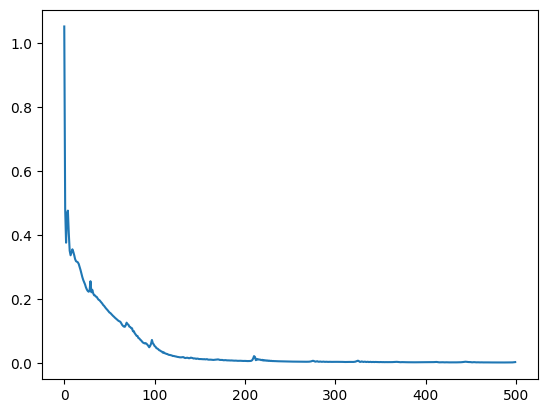

In [5]:
loss, valloss = train(trainloader_10, (embedding, encoder, decoder), optimizer, 500, example_images=example_images, device=device)

plt.plot(loss)
plt.plot(valloss)

# Auto-encoder MNIST
Use full dataset and validation set. 

In [6]:
embedding, encoder, decoder = getViT(D=128, patch_size=4, encoder_blocks=2, encoder_heads=4, decoder_blocks=2, decoder_heads=4, device=device)

optimizer = optim.Adam(list(embedding.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)#0.0001
example_images = next(iter(trainloader))[0][:10].to(device)

print("Parameter of Embedding: ", count_parameters(embedding))
print("Parameter of Encoder: ", count_parameters(encoder))
print("Parameter of Decoder: ", count_parameters(decoder))

Parameter of Embedding:  10512
Parameter of Encoder:  199168
Parameter of Decoder:  331776


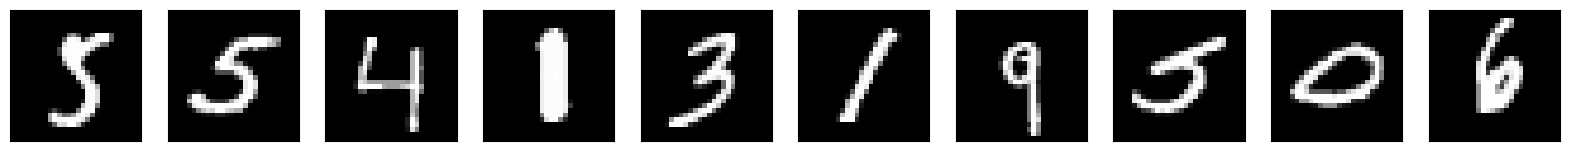

100%|██████████| 469/469 [01:51<00:00,  4.20it/s]


Epoch 1 loss: 0.13606898259045855


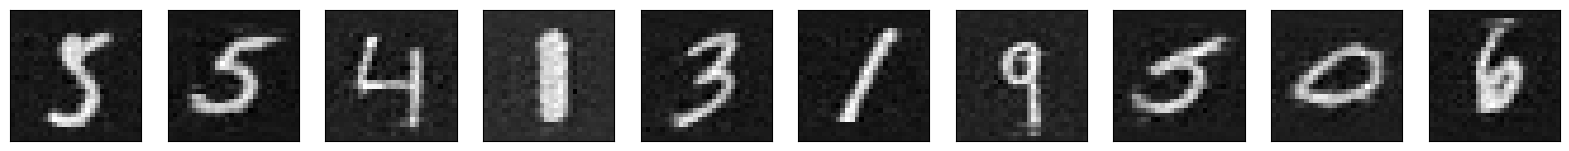

100%|██████████| 469/469 [01:28<00:00,  5.33it/s]


Epoch 2 loss: 0.010985188522755401


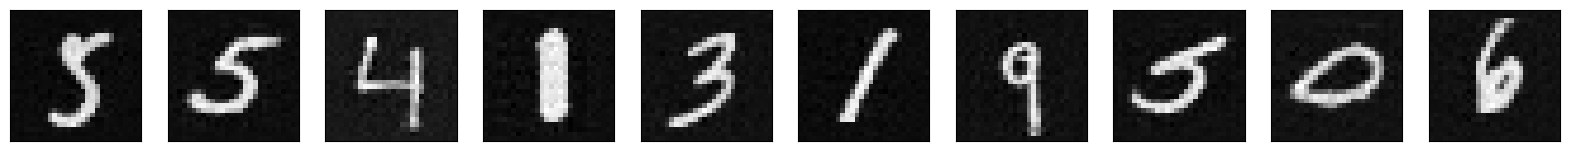

100%|██████████| 469/469 [01:30<00:00,  5.16it/s]


Epoch 3 loss: 0.00391668661324772


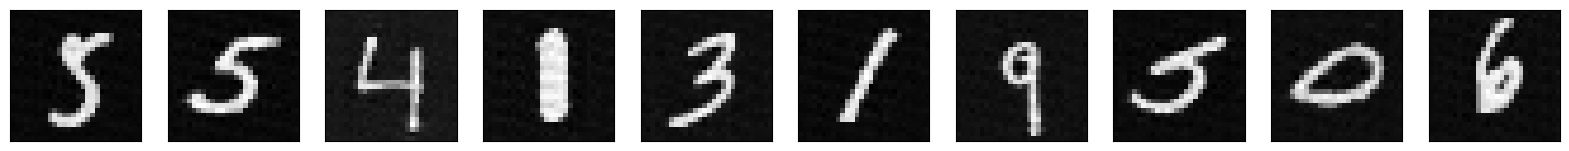

100%|██████████| 469/469 [01:50<00:00,  4.25it/s]


Epoch 4 loss: 0.0022198025247395863


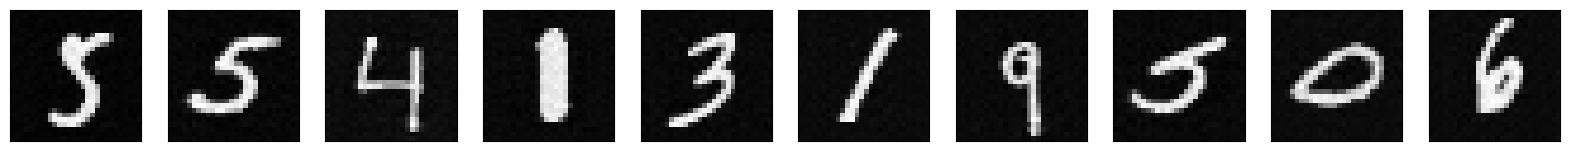

100%|██████████| 469/469 [02:18<00:00,  3.40it/s]


Epoch 5 loss: 0.001540549773363464


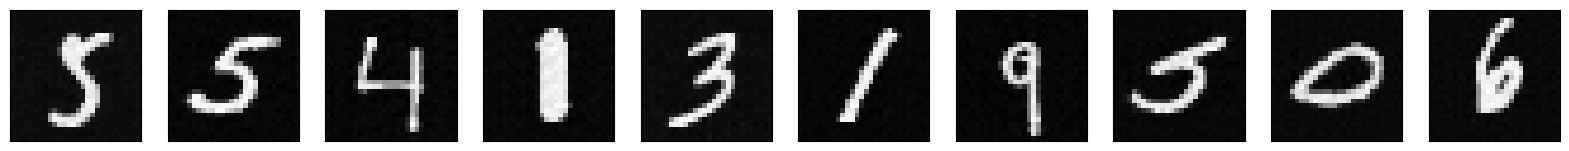

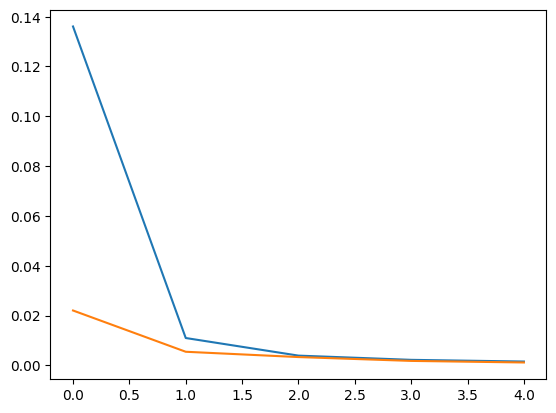

In [7]:
loss, valloss = train(trainloader, (embedding, encoder, decoder), optimizer, 5, valloader=valloader, example_images=example_images, device=device, epoch_progress=True)

plt.plot(loss)
plt.plot(valloss)

# Comparison with off-the-shelf ViT encoder
To further verify our own implementation we empirically compare it with a popular off-the-shelf ViT encoder (PyTorch's ViT has fixed input sizes of 224x224). The task for both is to reconstruct MNIST images and both get the same MLP decoder. The parameters are mostly the same, with probably small differences in some details. 

We compare the training curves, empirical reconstruction quality and run time. 

In [8]:
from vit_pytorch import ViT

Parameter of Autoencoder:  355232


100%|██████████| 469/469 [01:04<00:00,  7.29it/s]


Epoch 1 of 10, Train Loss: 0.182, Test Loss: 0.094


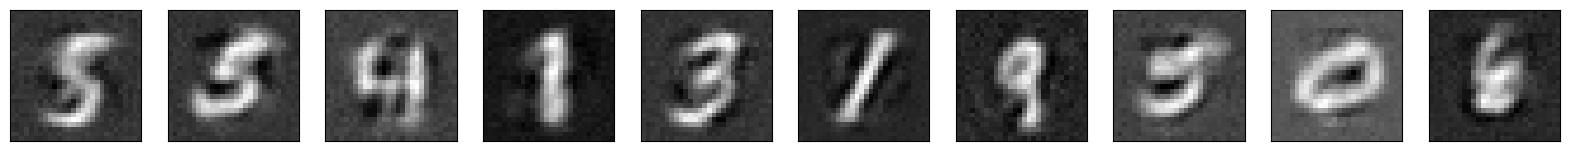

100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


Epoch 2 of 10, Train Loss: 0.078, Test Loss: 0.069


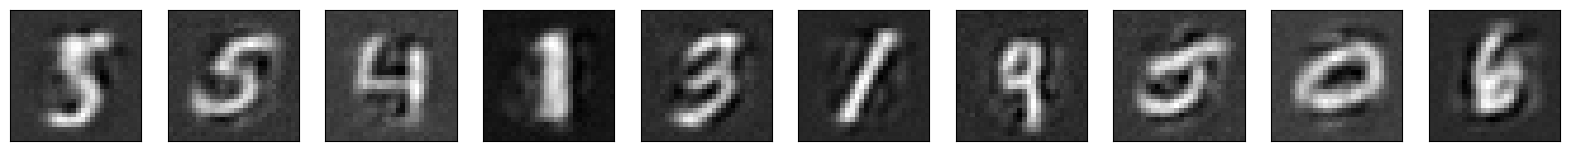

100%|██████████| 469/469 [00:52<00:00,  9.01it/s]


Epoch 3 of 10, Train Loss: 0.067, Test Loss: 0.060


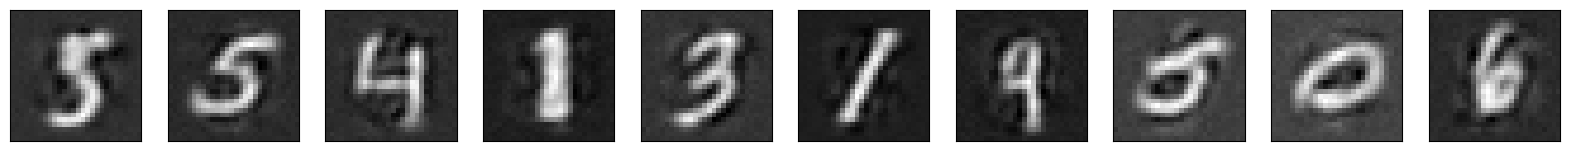

100%|██████████| 469/469 [00:41<00:00, 11.41it/s]


Epoch 4 of 10, Train Loss: 0.056, Test Loss: 0.051


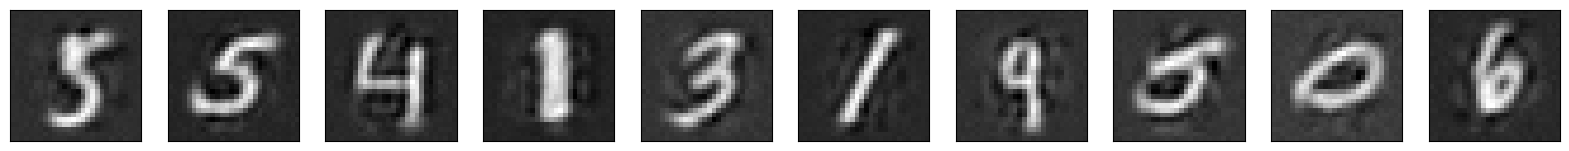

100%|██████████| 469/469 [00:41<00:00, 11.21it/s]


Epoch 5 of 10, Train Loss: 0.049, Test Loss: 0.046


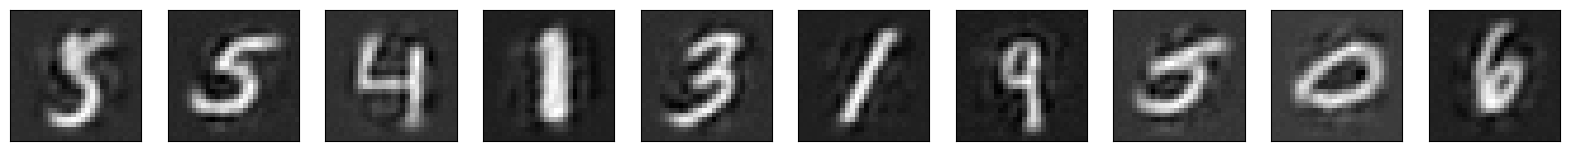

100%|██████████| 469/469 [00:40<00:00, 11.46it/s]


Epoch 6 of 10, Train Loss: 0.044, Test Loss: 0.042


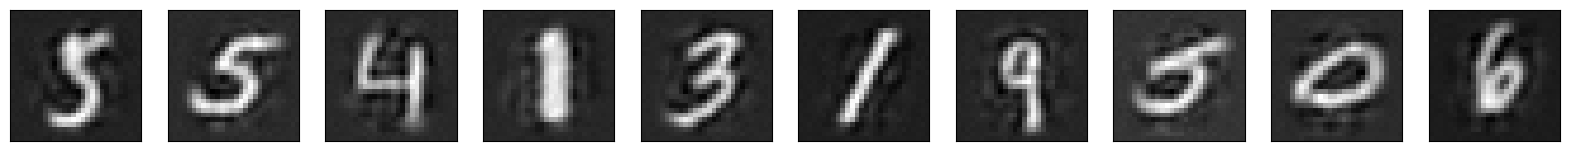

100%|██████████| 469/469 [00:41<00:00, 11.39it/s]


Epoch 7 of 10, Train Loss: 0.041, Test Loss: 0.039


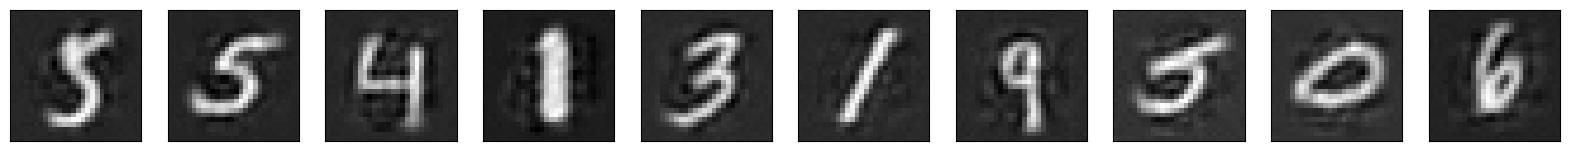

100%|██████████| 469/469 [00:40<00:00, 11.48it/s]


Epoch 8 of 10, Train Loss: 0.039, Test Loss: 0.037


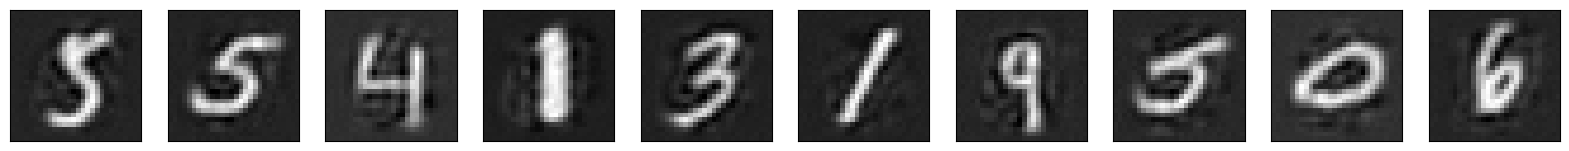

100%|██████████| 469/469 [00:41<00:00, 11.28it/s]


Epoch 9 of 10, Train Loss: 0.037, Test Loss: 0.036


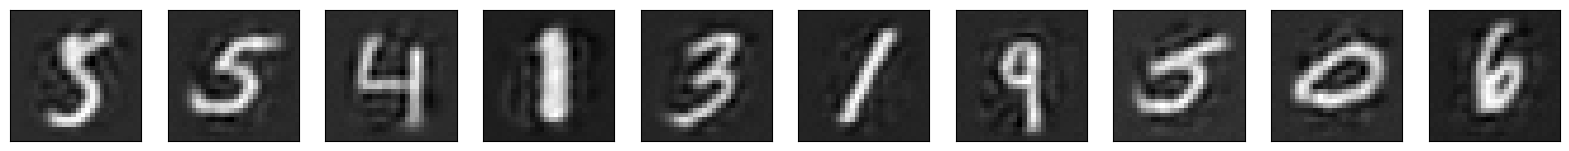

100%|██████████| 469/469 [00:40<00:00, 11.44it/s]


Epoch 10 of 10, Train Loss: 0.035, Test Loss: 0.034


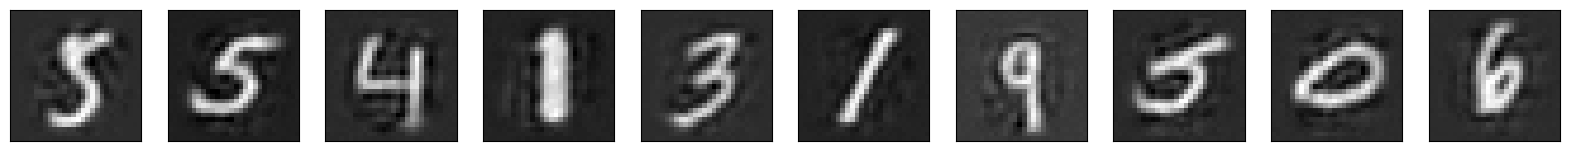

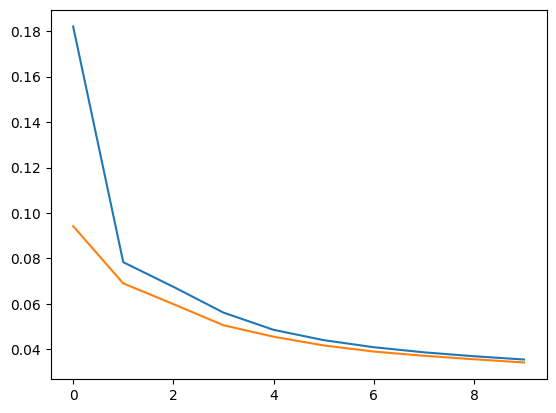

In [9]:
model = ViT(
    image_size = 28,
    patch_size = 4,
    num_classes = 128,
    dim = 128,
    depth = 2,
    heads = 4,
    channels=1,
    mlp_dim = 128,
    dropout = 0.0,
    emb_dropout = 0.0
)

# Create the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, model):
        super(Autoencoder, self).__init__()
        self.encoder = model
        self.decoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 784)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder(model).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("Parameter of Autoencoder: ", count_parameters(model))

epochs = 10
loss_history_1 = []
vloss_history_1 = []
for e in range(epochs):
    running_loss = 0.0
    running_vloss = 0.0
    for data, _ in tqdm(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = F.mse_loss(output, data.view(-1, 28 * 28))
        running_loss += loss.item() 
        loss.backward()
        optimizer.step()
    loss_history_1.append(running_loss / len(trainloader))

    with torch.no_grad():
        for data, _ in valloader:
            data = data.to(device)
            output = autoencoder(data)
            vloss = F.mse_loss(output, data.view(-1, 28 * 28))
            running_vloss += vloss.item()
        vloss_history_1.append(running_vloss / len(valloader))
    
    print('Epoch {} of {}, Train Loss: {:.3f}, Test Loss: {:.3f}'.format(
        e + 1, epochs, running_loss / len(trainloader), running_vloss / len(valloader)))
    
    # plot example images
    with torch.no_grad():
        y = autoencoder(example_images.to(device))
        plot_images(y.detach().cpu().numpy(), min(10, len(example_images)))

plt.plot(loss_history_1)
plt.plot(vloss_history_1)

In [10]:
embedding, encoder, decoder = getViT(D=128, patch_size=4, encoder_blocks=2, encoder_heads=4, decoder_blocks=1, decoder_heads=1, device=device)
decoder = nn.Sequential(
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128)
).to(device)

optimizer = optim.Adam(list(embedding.parameters()) + list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
example_images = next(iter(trainloader))[0][:10].to(device)

embedding_count, encoder_count, decoder_count = count_parameters(embedding), count_parameters(encoder), count_parameters(decoder)

print("Parameter of Embedding: ", embedding_count)
print("Parameter of Encoder: ", encoder_count)
print("Parameter of Decoder: ", decoder_count)
print("Total Parameter: ", embedding_count + encoder_count + decoder_count)

Parameter of Embedding:  10512
Parameter of Encoder:  199168
Parameter of Decoder:  33024
Total Parameter:  242704


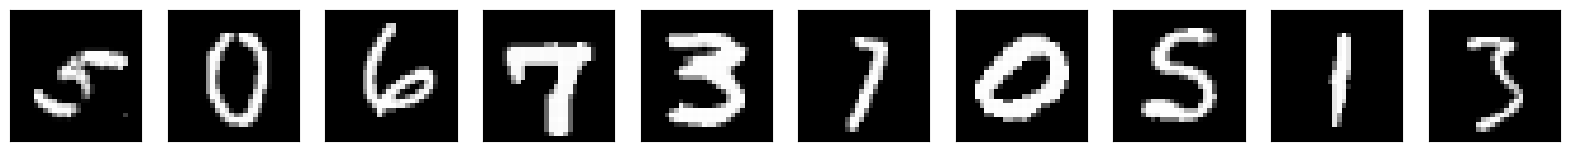

100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Epoch 1 loss: 0.14813013055494853


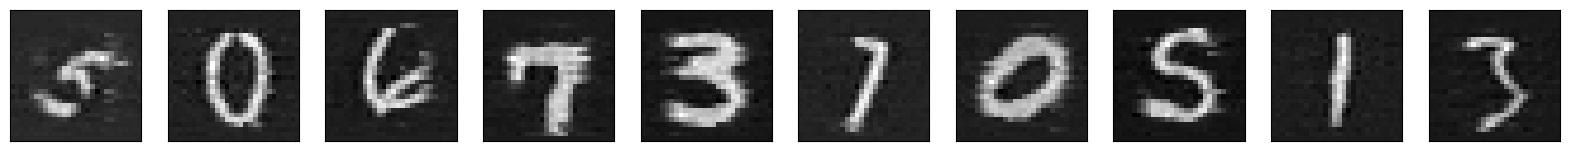

100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Epoch 2 loss: 0.018493378144710748


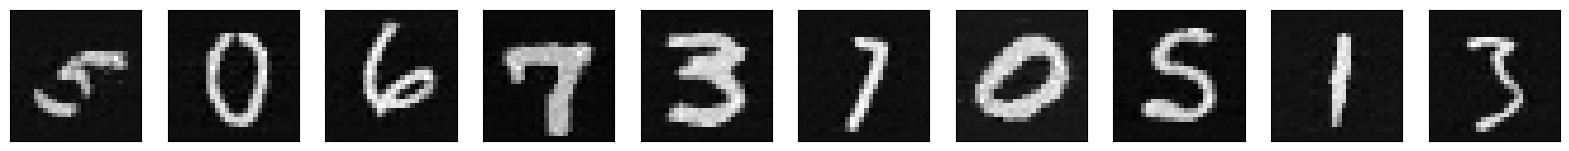

100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Epoch 3 loss: 0.005042749957969861


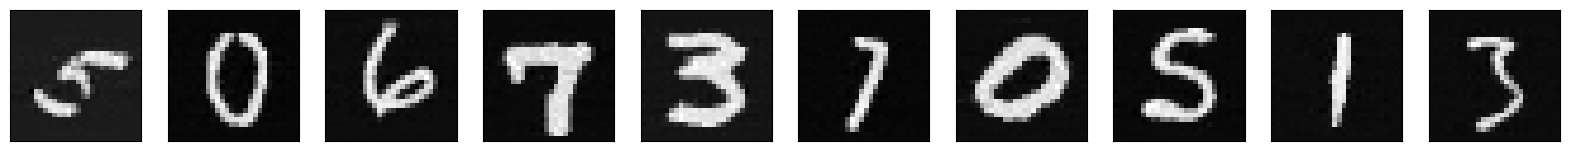

100%|██████████| 469/469 [00:40<00:00, 11.63it/s]


Epoch 4 loss: 0.002710061060931923


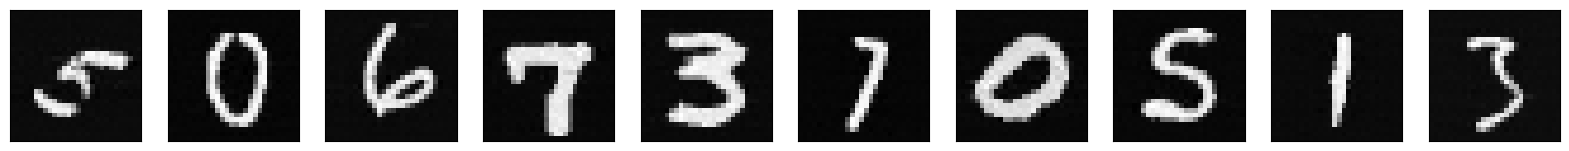

100%|██████████| 469/469 [00:38<00:00, 12.15it/s]


Epoch 5 loss: 0.0018078432384151608


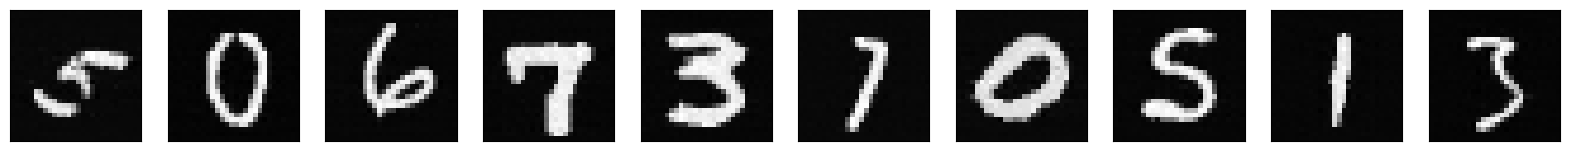

100%|██████████| 469/469 [00:38<00:00, 12.22it/s]


Epoch 6 loss: 0.0013677304388949277


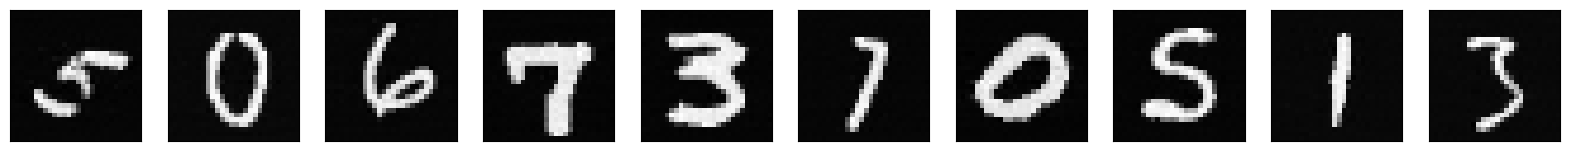

100%|██████████| 469/469 [00:38<00:00, 12.13it/s]


Epoch 7 loss: 0.0011523408446161112


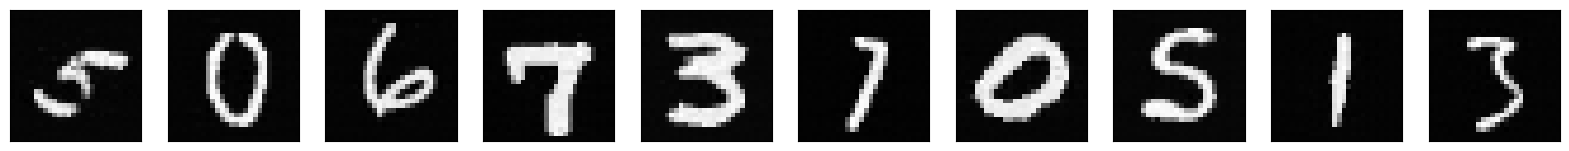

100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Epoch 8 loss: 0.0009637052726461245


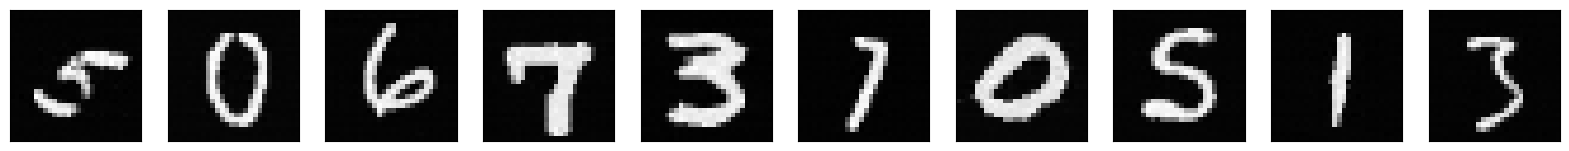

100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Epoch 9 loss: 0.0007692994730450761


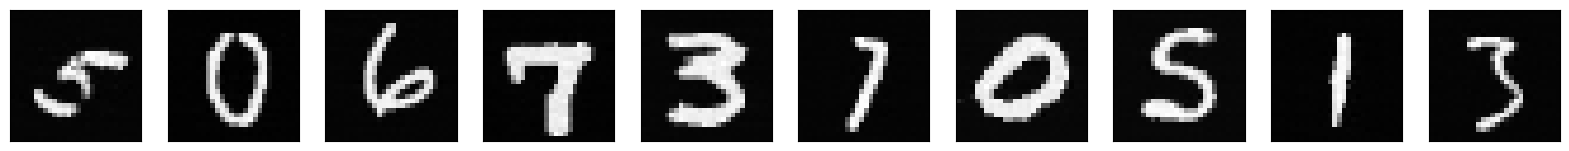

100%|██████████| 469/469 [00:38<00:00, 12.22it/s]


Epoch 10 loss: 0.00070626885764974


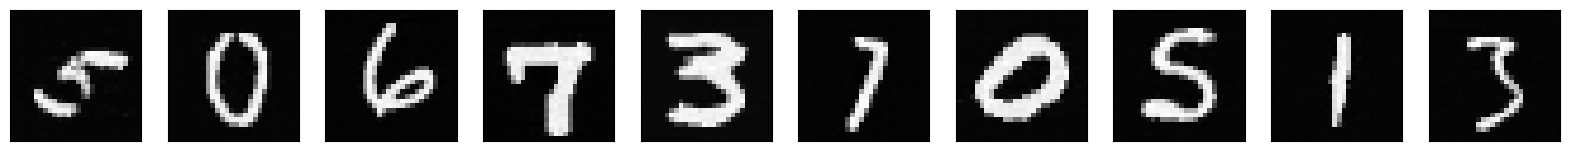

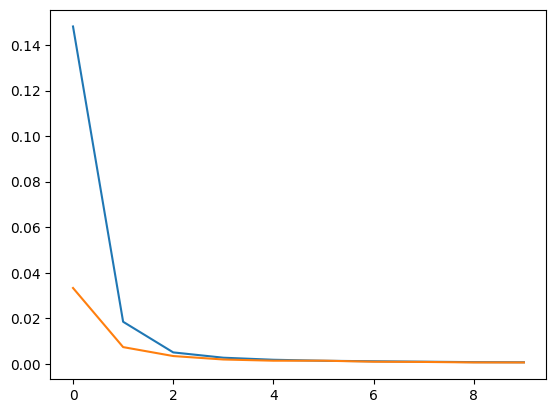

In [11]:
loss, valloss = train(trainloader, (embedding, encoder, decoder), optimizer, 10, valloader=valloader, example_images=example_images, device=device, epoch_progress=True)

plt.plot(loss)
plt.plot(valloss)

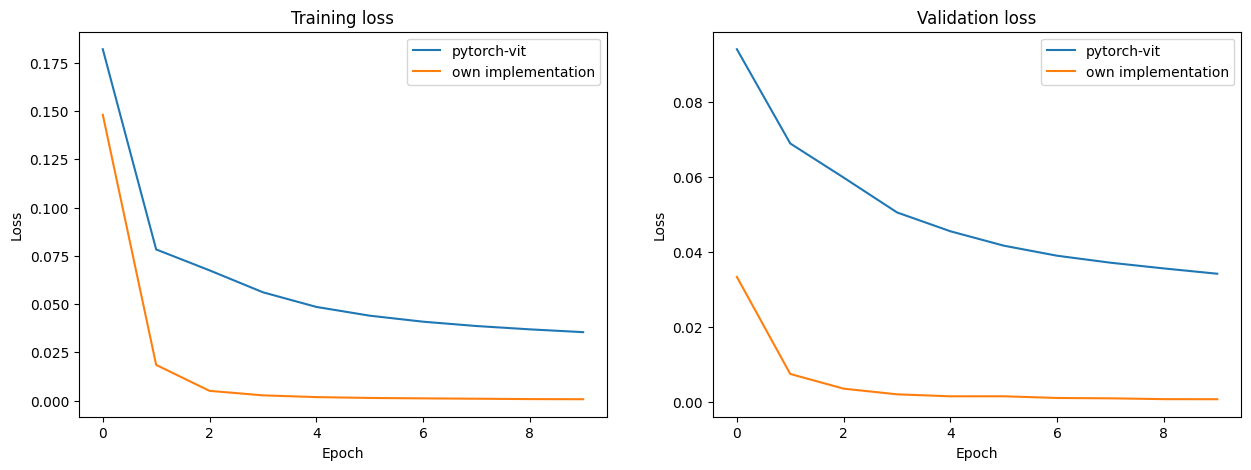

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history_1, label='pytorch-vit')
plt.plot(loss, label='own implementation')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vloss_history_1, label='pytorch-vit')
plt.plot(valloss, label='own implementation')
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Result**: Both architecture learn to reconstruct the images pretty fast. Our own implementation seems to reduce the loss faster, while having less parameters. Also the run times are very similar (variance due to other processes running on the machine).